In [1]:
from gensim.models import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from tweet_sent_predictor.transformer.LowerCaseTransformer import LowerCaseTransformer
from tweet_sent_predictor.transformer.MentionFlagger import MentionFlagger
from tweet_sent_predictor.transformer.NumberFlagger import NumberFlagger
from tweet_sent_predictor.transformer.SplitterPunctuation import SplitterPunctuation
from tweet_sent_predictor.transformer.URLFlagger import URLFlagger
from tweet_sent_predictor.transformer.StopWordFilter import StopWordFilter

In [2]:
df = pd.read_csv("tweet_sent_predictor/data/train_proper.csv")

In [3]:
df

,opinion,brand,body
0,neu,apl,20 min line @apple store @short pump.
1,irr,msf,Nueva tecnología convierte cualquier superfici...
2,neu,ggl,Some people should not post replies in #Google...
3,neg,apl,I know a few others having same issue RT @Joel...
4,neg,msf,"#Microsoft - We put the """"backwards"""" into bac..."
...,...,...,...
4168,neg,apl,fuck this see you hoes @ work @WeakTwip @Munnn...
4169,neg,msf,"#Microsoft, #Adobe lose $13.5bn to piracy: Rep..."
4170,neu,twt,"I tried to explain why you would do """"The #Twi..."
4171,neg,apl,Installed io5 - fine on ipad but wiped wife's ...


In [4]:
df["body"]

0                   20 min line @apple store @short pump.
1       Nueva tecnología convierte cualquier superfici...
2       Some people should not post replies in #Google...
3       I know a few others having same issue RT @Joel...
4       #Microsoft - We put the ""backwards"" into bac...
                              ...                        
4168    fuck this see you hoes @ work @WeakTwip @Munnn...
4169    #Microsoft, #Adobe lose $13.5bn to piracy: Rep...
4170    I tried to explain why you would do ""The #Twi...
4171    Installed io5 - fine on ipad but wiped wife's ...
4172    #microsoft #careers site is giving errors for ...
Name: body, Length: 4173, dtype: object

In [5]:
pipe = Pipeline([
    ("Lowercase", LowerCaseTransformer()),
    ("MentionFlagger", MentionFlagger()),
    ("URLFlagger", URLFlagger()),
    ("NumberFlagger", NumberFlagger()),
    ("StopwordFilter", StopWordFilter()),
    ("SplitPoncutation", SplitterPunctuation())
])

In [6]:
data = pipe.fit_transform(df["body"])

In [7]:
data

0       [<NUMBER>, min, line, <MENTION>, store, <MENTI...
1       [nueva, tecnología, convierte, cualquier, supe...
2       [, people, not, post, replies, #google+, threa...
3       [, know, others, issue, rt, <MENTION>, <NUMBER...
4       [#microsoft, put, backwards, backwards, compat...
                              ...                        
4168    [fuck, see, hoes, @, work, <MENTION>, <MENTION...
4169    [#microsoft, #adobe, lose, $<NUMBER>.<NUMBER>b...
4170    [, tried, explain, would, #twitter, &#<NUMBER>...
4171    [installed, io<NUMBER>, fine, ipad, wiped, wif...
4172    [#microsoft, #careers, site, giving, errors, t...
Name: body, Length: 4173, dtype: object

In [8]:
w2v = Word2Vec(sentences=data, size=100, min_count=0, window=5, workers=3, iter=5)

In [9]:
w2v.wv.save_word2vec_format("tweet_sent_predictor/data/word_embedding")

In [10]:
w2v.wv.vectors

array([[-4.6041730e-01,  4.1667390e-01, -1.4113946e-01, ...,
         1.5916775e-01,  2.1835172e-01, -9.6621647e-02],
       [-5.7686466e-01,  5.2043104e-01, -2.0034365e-01, ...,
         2.1790195e-01,  2.8595877e-01, -6.5997742e-02],
       [-6.5400368e-01,  6.1357623e-01, -2.1764845e-01, ...,
         2.4362434e-01,  3.3630028e-01, -1.0339728e-01],
       ...,
       [-8.9144995e-03,  6.3669109e-03,  9.8960171e-04, ...,
         6.5261577e-03,  5.7883142e-03,  1.5112978e-03],
       [-7.5415699e-03,  2.4433013e-03, -3.0036520e-03, ...,
         2.2966207e-03, -1.4940643e-03, -1.6326903e-04],
       [-4.4318154e-03,  5.4119229e-03, -5.1276577e-03, ...,
         3.1257505e-04,  1.8416091e-03, -6.7059198e-05]], dtype=float32)

In [11]:
from sklearn.manifold import TSNE

In [12]:
vectors_2d = TSNE(n_components=2).fit_transform(w2v.wv.vectors)

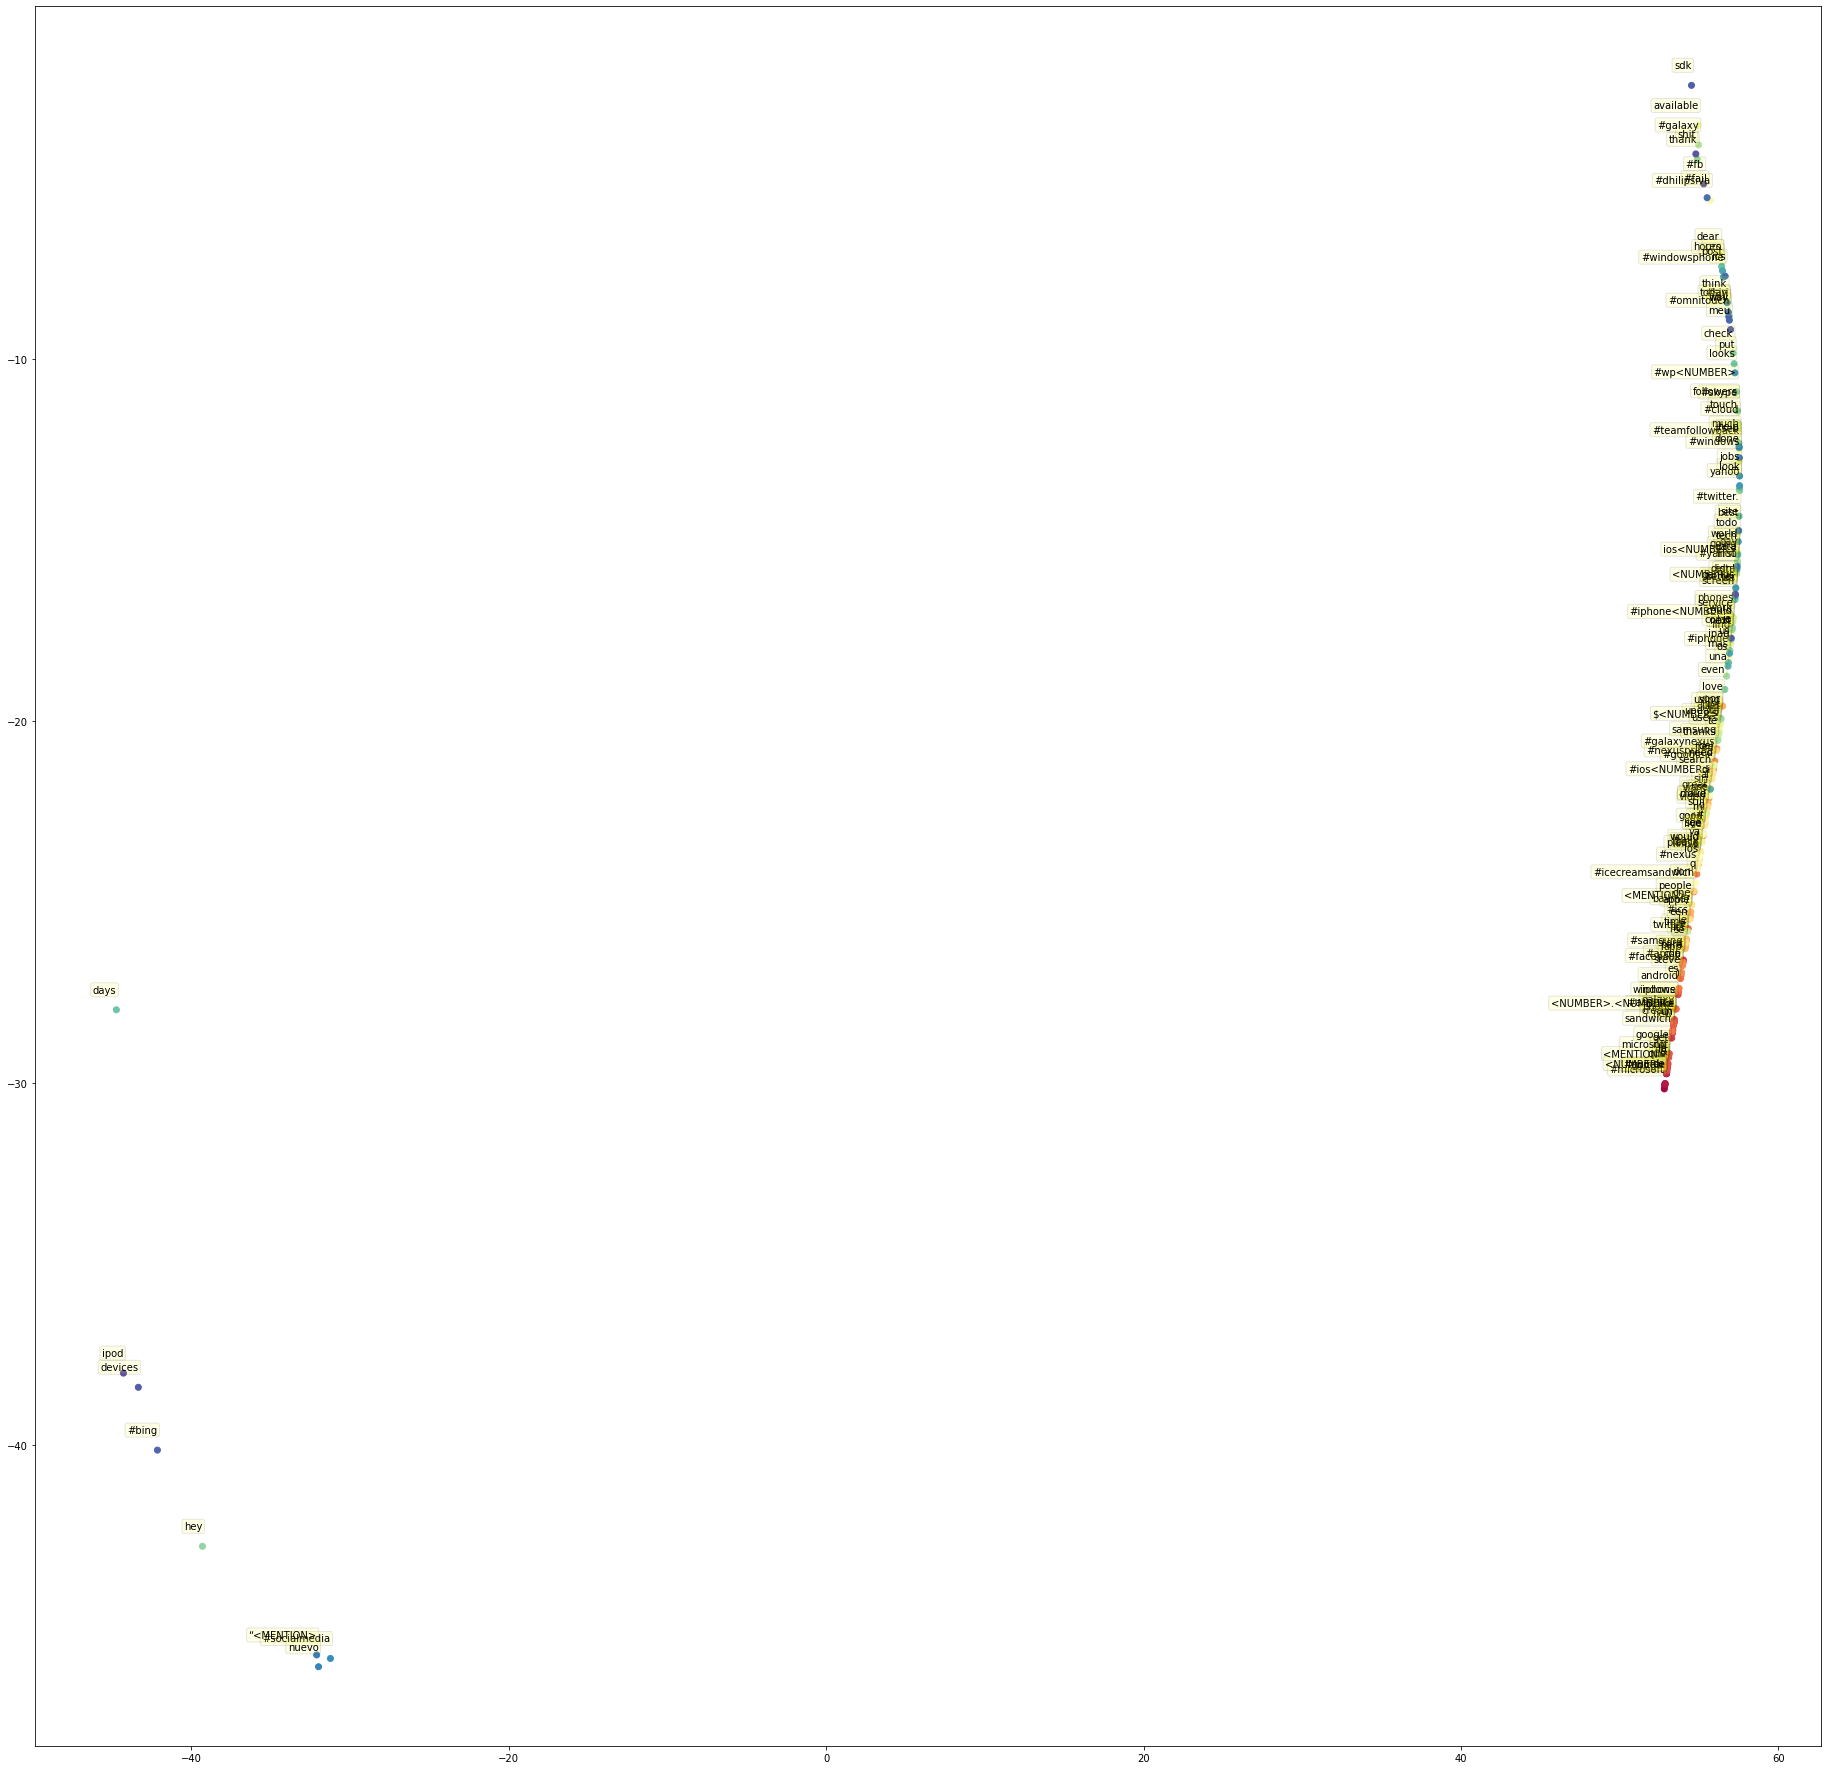

In [13]:
# Plot t-SNE result
plt.figure(figsize=(32, 32))
plt.scatter(vectors_2d[:200, 0], vectors_2d[:200, 1], marker='o', c=range(200), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(w2v.wv.index2word[:200], vectors_2d[:200, 0], vectors_2d[:200, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

In [14]:
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences

In [15]:
model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=len(w2v.wv.index2word),
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

model.add(Bidirectional(LSTM(100)))
model.add(Dense(n_categories, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_x, train_y, epochs=5, batch_size=64,
                    validation_data=(val_x, val_y), verbose=1)



NameError: name 'embedding_size' is not defined